## Modelling machine learning models (with GridSearch)
### 1. Logistic Regression
### 2. Linear SVC
### 3. Kernel SVM
### 4. Decision Trees
### 5. Random Forest
### 6. Gradient Boosted Decision Trees

## Before jumping into modelling, about Grid Search CV(cross-validation)
### In a brief, the representative advantages of Grid Search CV are 1) to figure out the optimal parameters for modelling and 2) validify crossly!

- GridSearchCV(model, # estimator
                param_grid=,   # parmaeters, dict type
                cv= 2 or KFold(2),  
                scoring=None,  # Classification problem=  'accuracy','f1'  
                               # Regression problem= 'neg_mean_squared_error','r2'...  
                n_jobs= 4,     # numbers of multi-processing/ -1 is all)  
                refit=True     # default= True)

In [1]:
# import Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import datetime
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Importing Dependencies for ML
from sklearn import linear_model  ## Logistic Regression Classifier
from sklearn.svm import LinearSVC  ## Support Vector Machine Classifier
from sklearn.svm import SVC  ## Support Vector Machine Classifier with kernel
from sklearn.tree import DecisionTreeClassifier  ## Decision Trees Classifier
from sklearn.ensemble import RandomForestClassifier  ## Random Forest Classifier
from sklearn.ensemble import GradientBoostingClassifier  ## Gradient Boosting Classifier

In [3]:
train= pd.read_csv(os.path.join('src', 'data','train.csv'))
test= pd.read_csv(os.path.join('src', 'data','test.csv'))

In [4]:
# get X_train and y_train from csv files
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

# get X_test and y_test from test csv file
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


## Let's model with the data

In [5]:
## setting up labels for plotting confusion matrix
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [6]:
## function for plotting confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### function to run model and check out the result

In [7]:
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

### Method to print the gridsearch

In [8]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

## 1. Logistic Regression with Grid Search

In [9]:
## importing Dependencies for logistic Regression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Done 
 

training_time(HH:MM:SS.ms) - 0:00:17.175162


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.010568


---------------------
|      Accuracy      |
---------------------

    0.9582626399728538


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 431  57   0   0   3]
 [  0  16 516   0   0   0]
 [  0   0   0 493   2   1]
 [  0   0   0   4 402  14]
 [  0   0   0  24   2 445]]


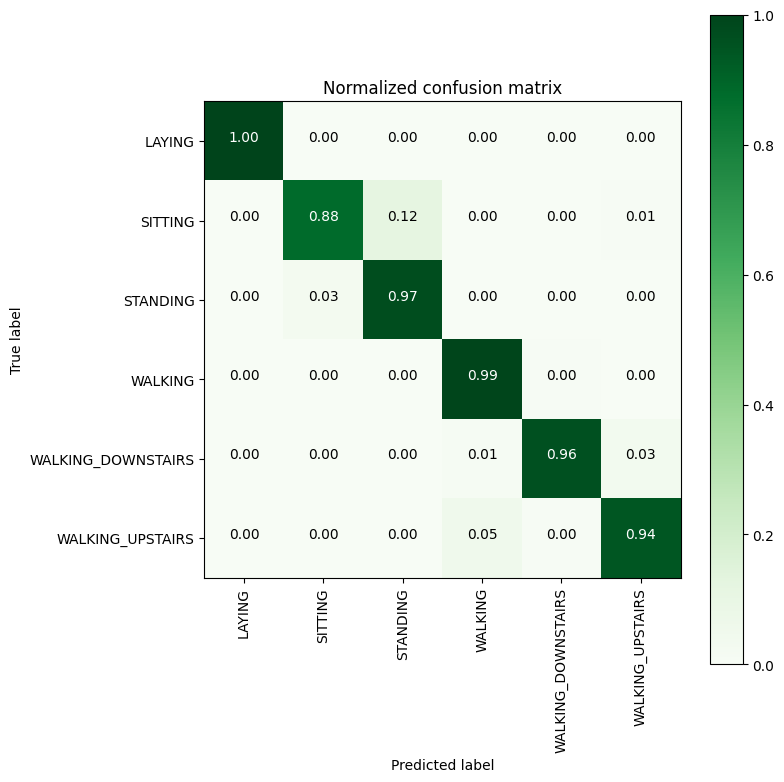

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [10]:
# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=8)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

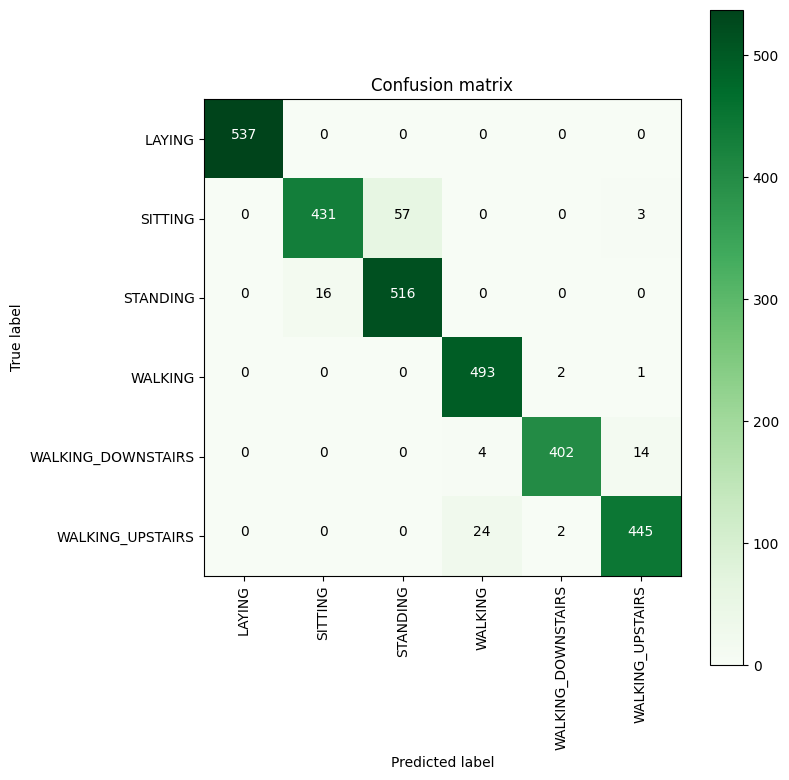

In [11]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

### 2. Linear SVC with GridSearch

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Done 
 

training_time(HH:MM:SS.ms) - 0:00:54.100770


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.009392


---------------------
|      Accuracy      |
---------------------

    0.9667458432304038


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  2 430  55   0   0   4]
 [  0  10 521   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   3 412   5]
 [  0   0   0  18   0 453]]


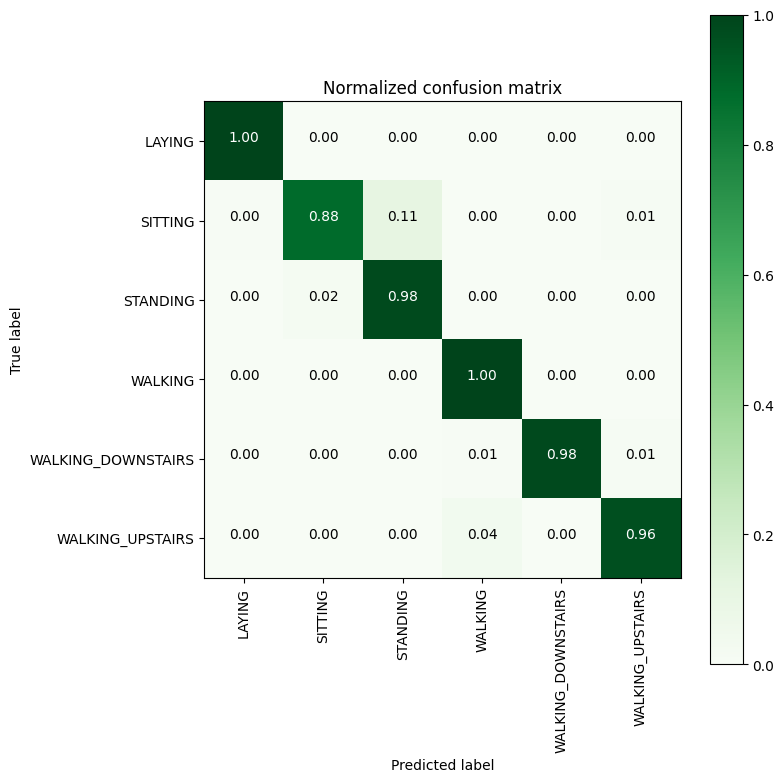

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.88      0.92       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=0.5, tol=5e-05)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.5}

---------------------------------
|   No of CrossValidation sets   |
---------

In [13]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}  # C : for regularizing component
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=8, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(lr_svc_grid_results['model'])

### 3. Kernel SVM with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:06:05.167036


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.365318


---------------------
|      Accuracy      |
---------------------

    0.9626739056667798


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


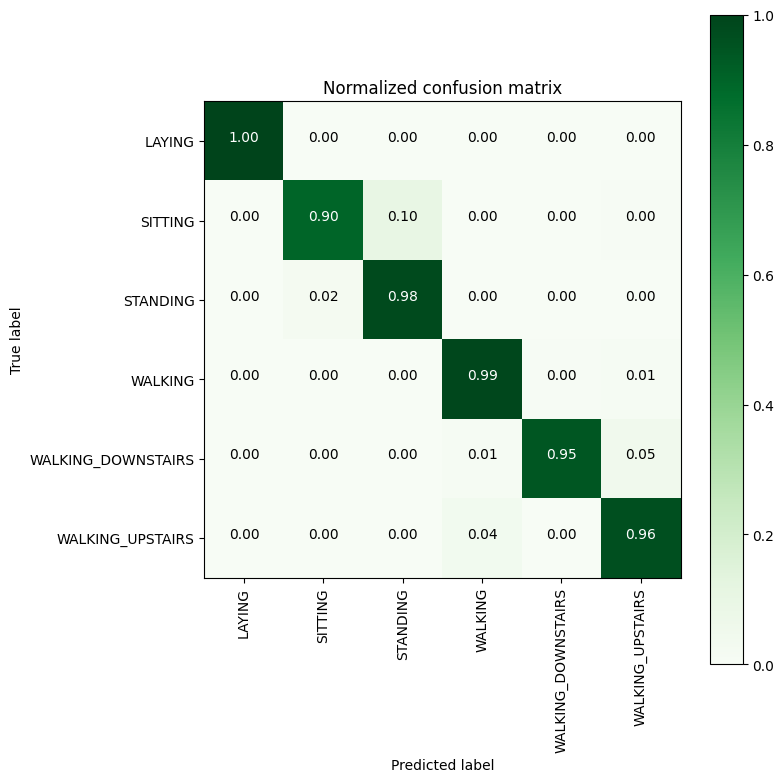

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=16, gamma=0.0078125)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 16, 'gamma': 0.0078125}

---------------------------------
|   No of CrossValidation 

In [14]:
parameters = {'C':[2,8,16], 'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf') # kernel = rbf
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=8)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rbf_svm_grid_results['model'])

### 4. Decision Trees with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:17.199006


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.010148


---------------------
|      Accuracy      |
---------------------

    0.838479809976247


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 400  91   0   0   0]
 [  0 113 419   0   0   0]
 [  0   0   0 470  10  16]
 [  0   0   0  49 266 105]
 [  0   0   0  86   6 379]]


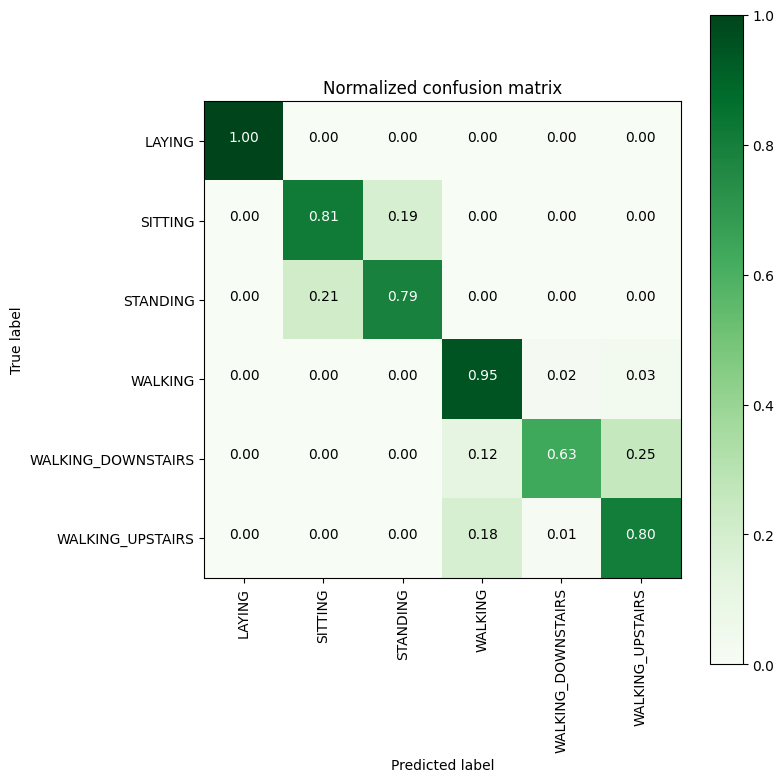

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.78      0.81      0.80       491
          STANDING       0.82      0.79      0.80       532
           WALKING       0.78      0.95      0.85       496
WALKING_DOWNSTAIRS       0.94      0.63      0.76       420
  WALKING_UPSTAIRS       0.76      0.80      0.78       471

          accuracy                           0.84      2947
         macro avg       0.85      0.83      0.83      2947
      weighted avg       0.85      0.84      0.84      2947

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(max_depth=5)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 5}

---------------------------------
|   No of CrossValidation sets

In [15]:
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=8)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

### 5. Random Forest Classifier with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:11:14.625230


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.074993


---------------------
|      Accuracy      |
---------------------

    0.9233118425517476


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 428  63   0   0   0]
 [  0  45 487   0   0   0]
 [  0   0   0 483   8   5]
 [  0   0   0  28 352  40]
 [  0   0   0  32   5 434]]


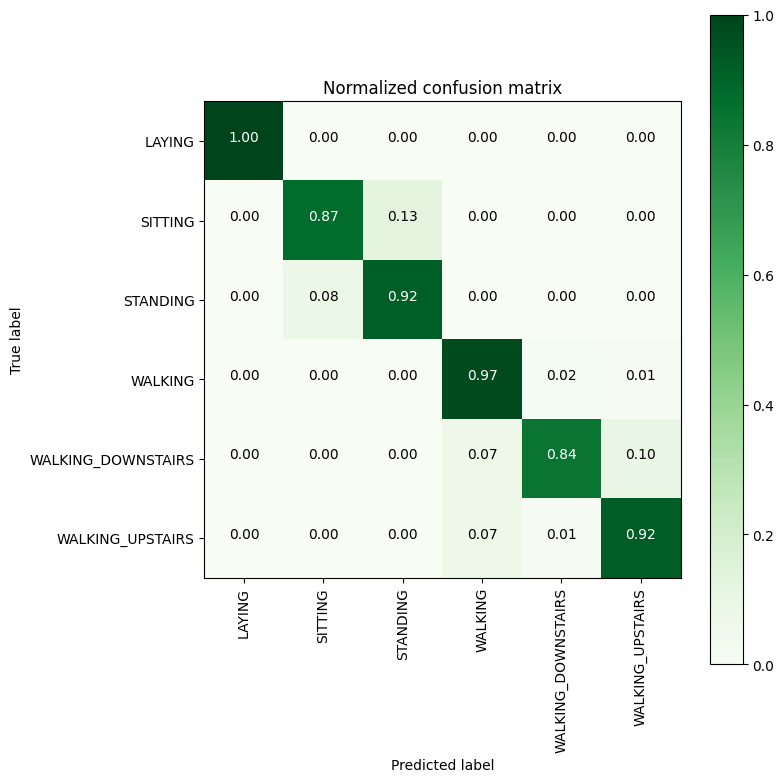

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.90      0.87      0.89       491
          STANDING       0.89      0.92      0.90       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.84      0.90       420
  WALKING_UPSTAIRS       0.91      0.92      0.91       471

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(max_depth=11, n_estimators=130)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 11, 'n_estimators': 130}

-----------------------

In [16]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=8)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rfc_grid_results['model'])

### 6. Gradient Boosted Decision Trees with GridSearch

In [ ]:
param_grid = {'max_depth': np.arange(5,8,1), \
             'n_estimators':np.arange(130,170,10)}
gbdt = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=8)
gbdt_grid_results = perform_model(gbdt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(gbdt_grid_results['model'])

training the model..


### 7. checking out all results of models

In [ ]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))
print('GradientBoosting DT : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                        100-(rfc_grid_results['accuracy'] * 100)))